# 1. As características de um problema não-supervisionado

O modelo nao-supervisionado funciona se baseando em convergir a partir da similaridade de atributos entre entidades diferentes. Por exemplo, a partir de frutas com atributos semelhantes (tamanho, cor, formato, etc) o não-supervisionado agrupa. Um dos maiores desafios deste tipo de modelo é que não existe resposta errada, todo algoritmo de clusterização retornará um cluster. Outro desafio é que toda a fundamentação de machine learning se baseia no erro e, por isso, a performance dos modelos são medidos mais na prática. 

Outro ponto importante é que, em geral, clusterização é o meio e não o fim. A ideia é sumarizar os dados por algum motivo. Por exemplo, no caso aqui são os "Insiders", que é um grupo reduzido a partir de um grande grupo. 

# PA 005 - High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução (IoT)

### 0.1. Input (Entrada)

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
    
2. Conjunto de dados
    - Vendas de um e-commerce online durante um periodo de um ano.

### 0.2. Output (Saída)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider


2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### 0.3 Tasks (Tarefas)

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
        - Faturamento
            - Alto ticket médio
            - Alto LTV (Life Time Value)
            - Baixa Recência (baixo tempo entre duas compras)
            - Alto Basket Size (tamanho da cesta de compras)
            - Baixa probabilidade de churn (churn é quando a empresa para de utilizar seu serviço)
            - Alta propensão de compra
            
        - Custo
            - Baixa taxa de devolução
            
        - Experiência de Compra
            - Média alta das avaliações
            
            
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
        - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes
        - Idade
        - Localização 
    
    - Características do consumo
        - Features da clusterização


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo insiders


5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Séries temporais (ARIMA, ARMA, HoltWinter, etc)
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mês, 3 meses, etc)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo


7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mês, 3 meses, etc)
    - A pessoa precisa ser disimilar ou não-parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de Hipóteses


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de Compra
    - Frete Grátis
    - Visita a empresa


# 0.0 Imports

In [6]:
import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib      import pyplot as plt
from IPython.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import umap.umap_ as umap

## 0.1 Helper Functions

In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width: 100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [8]:
# read data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

# drop exatra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

In [9]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descrição dos dados

## 1.1 Rename Columns

In [10]:
df1 = df_raw.copy()

In [11]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [12]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [13]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
160491,550458,21041,RED RETROSPOT OVEN GLOVE DOUBLE,1,16-Apr-17,5.79,NaN,United Kingdom


## 1.2 Data Dimensions

In [14]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [16]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

O fato de ter 135k customer_id sem identificação é um problema, uma vez que o objetivo é construir clusters identificando os clientes. A princípio, serão removidos 135k de linhas, mas é importante entender o que houve e o motivo de estarem assim.

## 1.5 Replace NA

In [17]:
# remove NA

df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1 - (df1.shape[0]/df_raw.shape[0])))

Removed data: 0.25


Ou seja, 25% do dataset foi removido.

In [18]:
df1.shape

(406829, 8)

Ainda assim, segue-se com mais de 400k de linhas, não será impeditivo do projeto seguir.

In [19]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change Dtypes

In [20]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [21]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [22]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
384498,570127,23433,HANGING QUILTED PATCHWORK APPLES,10,2017-10-05,0.83,16900,United Kingdom


In [23]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

Esta etapa será pulada por hora, depois será voltado aqui.

# 2.0 Feature Engineering

In [24]:
df2 = df1.copy()

## 2.1 Feature Creation

In [25]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


Será criado uma tabela de referência, com a menor granularidade possível

In [26]:
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [27]:
# Gross Revenue (Faturamento) = quantity * price
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

# Monetary (Quanto esta pessoa gastou na loja)
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Adicionando no datafram de referencia
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day Purchase
# Como o dataset é antigo, será escolhido a data como a última data de compra do dataset. Esta data servirá de referencia, uma vez que o recorte dos dados é de dois anos atrás.
# em um projeto real, é selecionado o datetime.today(), selecionando assim a data de HOJE.
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# 3.0 Data Filtering

In [28]:
df3 = df_ref.copy()

# 4.0 EDA - Exploratory Data Analysis

In [29]:
df4 = df3.copy()

# 5.0 Data Preparation

In [30]:
df5 = df4.copy()

# 6.0 Feature Selection

In [31]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [32]:
X = df6.drop(columns=['customer_id'])

## 7.1 Within-Cluster Sum of Squares (WSS)

In [33]:
from yellowbrick.cluster import KElbowVisualizer

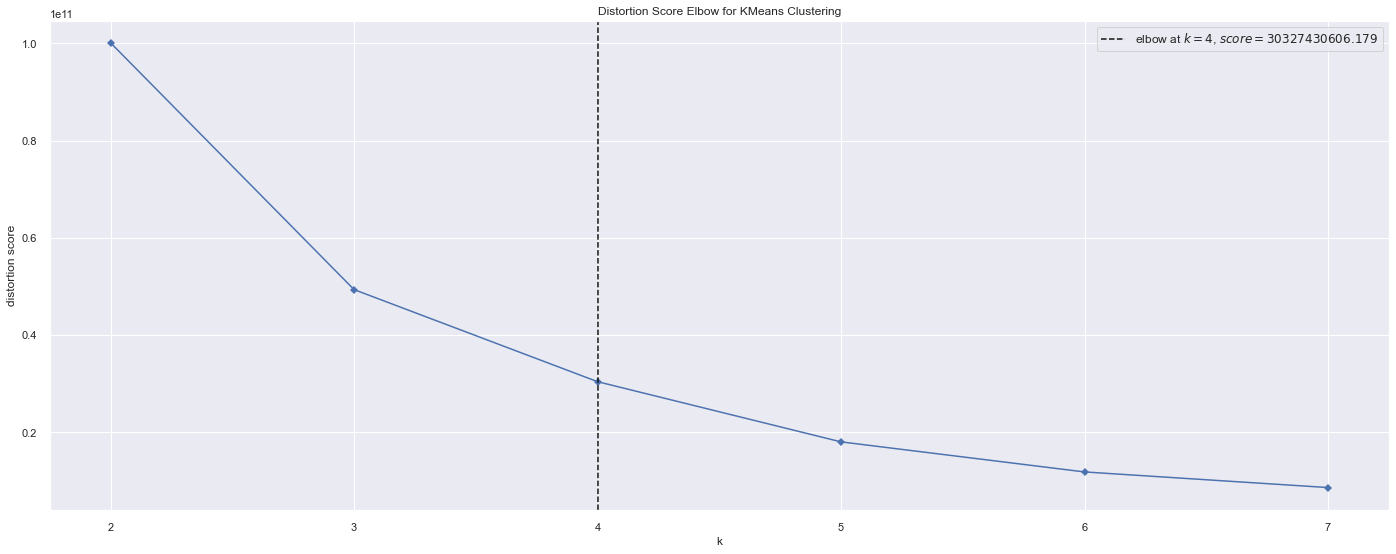

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
clusters = [2,3,4,5,6,7]
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score (SS)

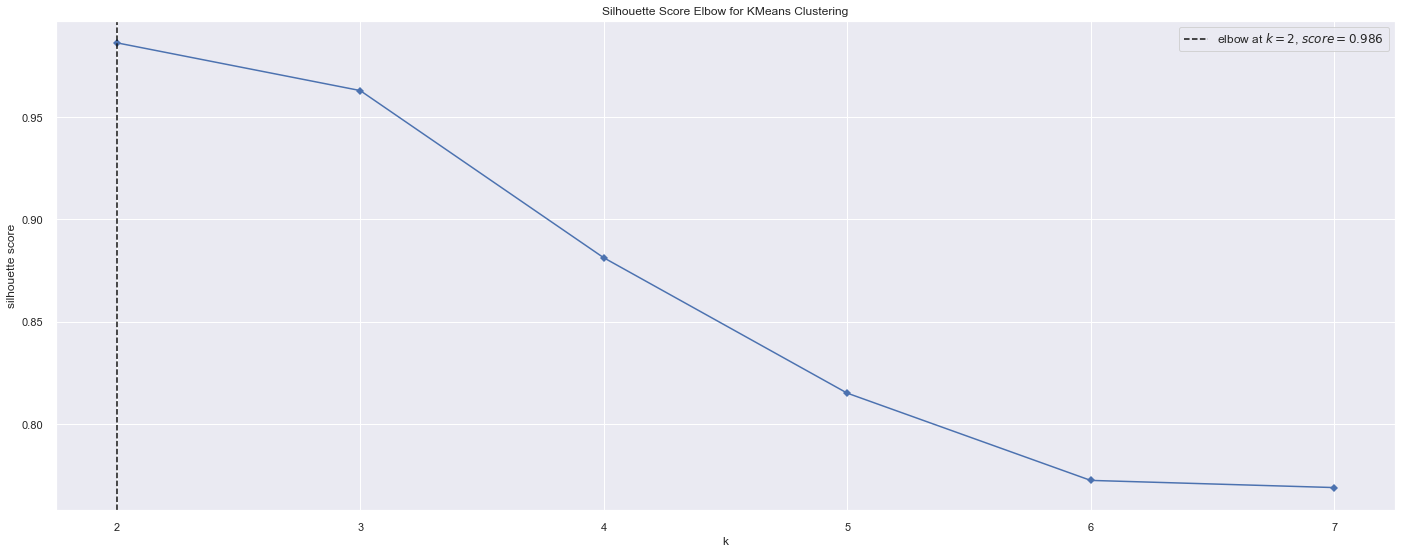

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

Então, o WSS indicou um total de 3 clusters, enquanto a SS indicou 2 clusters. A escolha é preferível ser a partir da SS, já que considera a distância intra cluster e entre clusters. Porém, se observar os valores de score para a SS, usar 2 ou 3 não influenciará muito negativamente, já que os valores de score não são tão diferentes. Por isso, será optado por utilizar k = 3 a princípio.

## 7.3 Silhouette Analysis

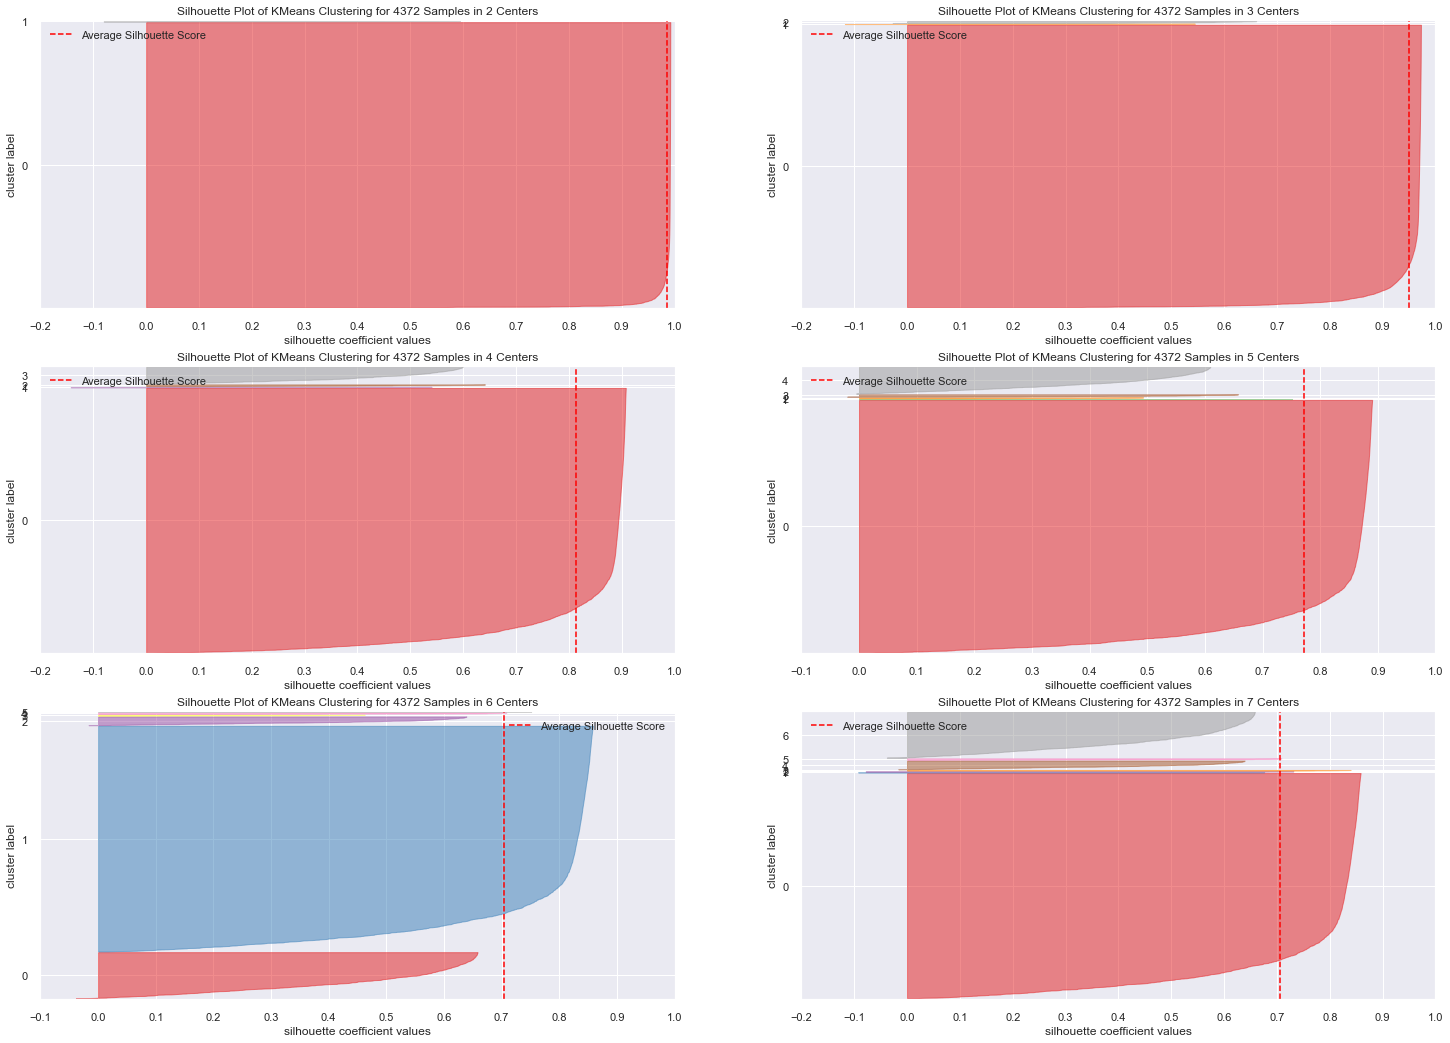

In [36]:
fig,ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

A princípio, existe um cluster muito maior que os outros que engloba a maior parte dos dados. As métricas não funcionarão bem.

# 8.0 Model Training

## 8.1 K-Means

In [37]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [38]:
print(  f'WSS Value: {kmeans.inertia_}')
print(f'Silhouette Score: {m.silhouette_score(X, labels, metric="euclidean")}')

WSS Value: 40056506734.60248
Silhouette Score: 0.8139972028952444


# 9.0 Cluster Analysis

In [39]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspectionb

In [40]:
 #fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
 #fig.show()

## 9.2 Visualization Silhouette Visualizer

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


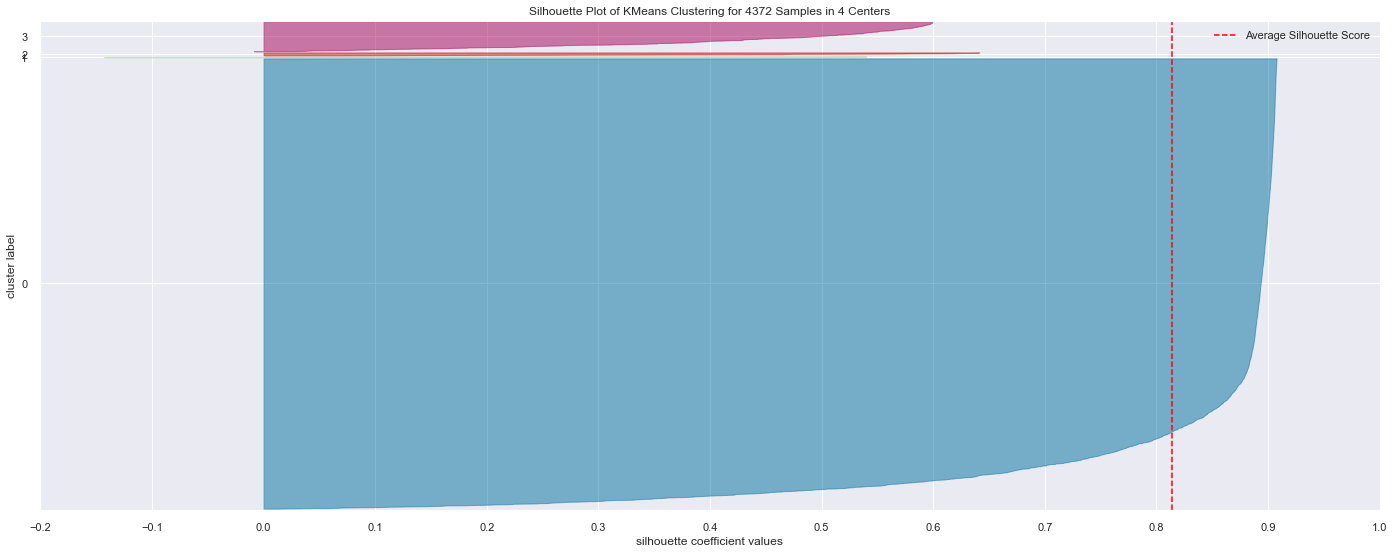

In [41]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

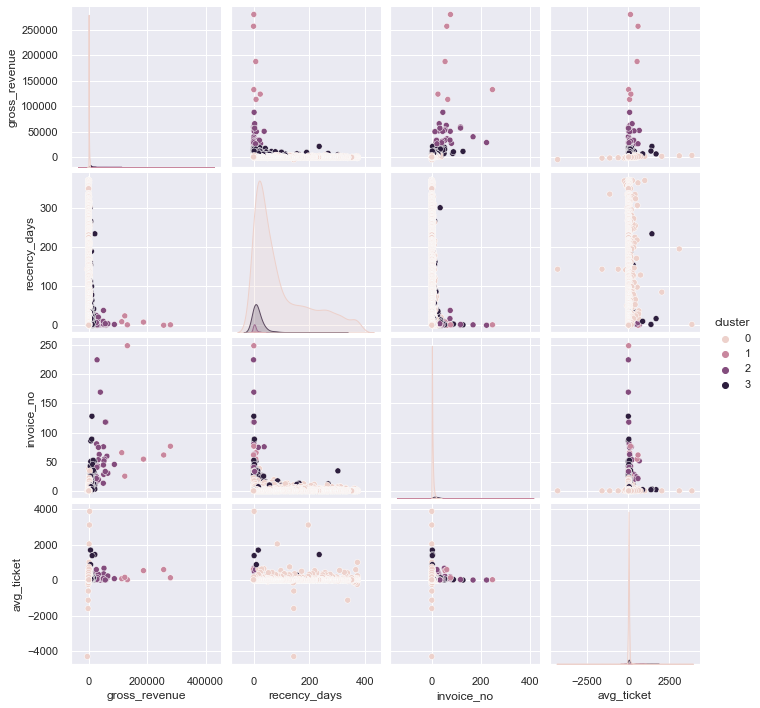

In [42]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

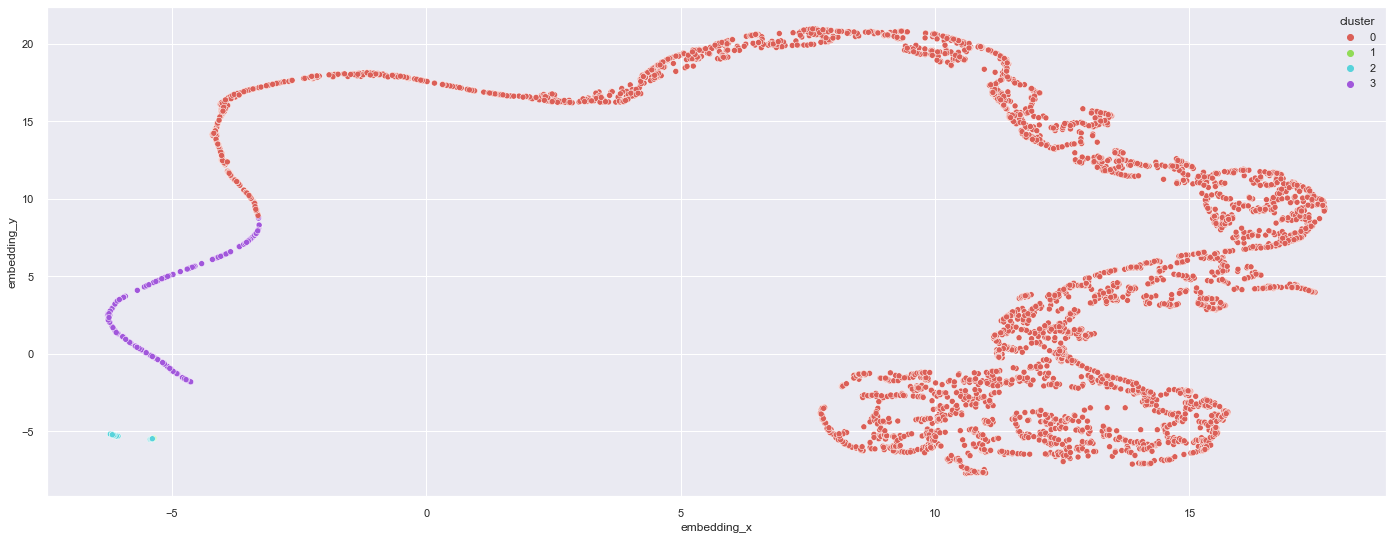

In [44]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data=df_viz)

## 9.4 Cluster Profile

In [46]:
# number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum() )

# average gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days, how='inner', on='cluster')

# average invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invoice_no, how='inner', on='cluster')

# average ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


Se fosse da forma como está definido, o cluster 1, referente aos insiders, que é o cluster com menor recency e maior gross_revenue, seria formado por apenas 6 pessoas.
Além disso, este grupo de 6 pessoas tem um gasto de $182k em média, o que é muito acima de qualquer um dos outros clusters.
Este mesmo cluster tem um tempo de retorno em compra de 7 dias, o que é muito inferior aos outros, o que é excelente para o negócio. Além de ter um total de 89 compras.

### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0.14% dos customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00
    
### Cluster 02:

    - Número de customers: 31 (0.71% dos customers)
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52
    
### Cluster 03:

    - Número de customers: 4.335 (99% dos customers)
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57

# 10.0 Deploy to Production